### Introduction

In this notebook, we delve into the renowned Titanic dataset, a staple in the machine learning community for exploring classification algorithms. The primary objective is to predict survival outcomes based on various passenger attributes. To achieve this, we implement a comprehensive data processing and analysis pipeline, utilizing Python and its powerful libraries.

The core of our approach is the DataPreprocessor class, designed to streamline the preprocessing steps including feature engineering, data cleaning, and transformation. We employ various machine learning models such as Logistic Regression, Gradient Boosting, Random Forest, and XGBoost, testing their efficacy in predicting survival rates. Additionally, the notebook showcases exploratory data analysis (EDA) to glean insights from the dataset and understand underlying patterns.

Key aspects of our pipeline include handling missing values, feature scaling and encoding, and model evaluation with cross-validation. The objective is not just to build a predictive model but also to understand the data deeply through visualizations and statistical analysis.

In [3]:
import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")
df= pd.read_csv('train_titanic.csv')

In [4]:
import pandas as pd
from itertools import chain, combinations
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ClassificationReport, ROCAUC, PrecisionRecallCurve, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve

class DataPreprocessor:
    def __init__(self, df):
        """
        Initialize the DataPreprocessor class with a DataFrame.
        Args:
            df (DataFrame): The DataFrame to preprocess.
        """
        self.df = df

    def remove_columns(self, columns):
        """
        Remove specified columns from the DataFrame.
        Args:
            columns (list or str): Column names to remove.
        """
        self.df.drop(columns, axis=1, inplace=True)
    
    def bin_age_and_remove_original(self):
        """
        Categorize the 'Age' column into bins and remove the original 'Age' column.
        """
        bins = [0, 12, 20, 40, 60, np.inf]
        labels = ['Child', 'Teenager', 'Adult', 'MiddleAge', 'Senior']
        self.df['AgeGroup'] = pd.cut(self.df['Age'], bins, labels=labels)
        self.remove_columns('Age') # Remove the original Age column

    def convert_sex_to_numeric(self):
        """
        Convert gender entries in the 'Sex' column to numeric values (0 and 1).
        """
        self.df['Sex'] = self.df['Sex'].map({'female': 0, 'male': 1})

    def extract_and_transform_titles(self):
        """
        Extract titles from passenger names, transform and create dummy variables, then remove the 'Title' column.
        """
        self.df['Title'] = self.df['Name'].apply(self.extract_title)
        self.df['Title'] = self.df['Title'].apply(self.merge_titles)

        # Create dummy variables for the transformed titles
        title_dummies = pd.get_dummies(self.df['Title'], prefix='Title')
        self.df = pd.concat([self.df, title_dummies], axis=1)

        # Remove the original 'Title' and 'Name' columns
        self.remove_columns(['Title', 'Name'])

    @staticmethod
    def extract_title(name):
        """
        Extract the title from a given name string.
        Args:
            name (str): Name string to extract the title from.
        Returns:
            str: Extracted title.
        """
        title_search = re.search(' ([A-Za-z]+)\.', name)
        if title_search:
            return title_search.group(1)
        return ""

    @staticmethod
    def merge_titles(title):
        """
        Consolidate various titles into broader categories.
        Args:
            title (str): Title to categorize.
        Returns:
            str: Categorized title.
        """
        if title in ['Don', 'Rev', 'Dr', 'Major', 'Col', 'Capt', 'Jonkheer']:
            return 'Professional'
        elif title in ['Sir', 'Countess']:
            return 'Mr'
        elif title in ['Mme', 'Ms','Lady','Dona']:
            return 'Mrs'
        elif title == 'Mlle':
            return 'Miss'
        elif title == 'Master':
            return 'Child'
        else:
            return title

    def cap_fare_values(self):
        """
        Cap the 'Fare' values at specified percentiles to reduce skewness.
        """
        lower_cap_threshold = self.df['Fare'].quantile(0.01)
        upper_cap_threshold = self.df['Fare'].quantile(0.99)
        self.df['CappedFare'] = self.df['Fare'].clip(lower=lower_cap_threshold, upper=upper_cap_threshold)
        self.remove_columns('Fare')

    def handle_cabin_columns(self):
        """
        Process the 'Cabin' column, creating new features and handling missing values.
        """
        self.df['CabinMissing'] = self.df['Cabin'].isnull().astype(int)
        self.df['CabinPrefix'] = self.df['Cabin'].str[0]
        self.df['CabinPrefix'].fillna('unknown',inplace = True)
        self.remove_columns(['Cabin'])

    def handle_embarked(self):
        """
        Handle missing values in 'Embarked' column and perform one-hot encoding.
        """
        # Fill missing values with the mode
        self.df['Embarked'].fillna(self.df['Embarked'].mode()[0], inplace=True)

        # One-hot encoding
        embarked_dummies = pd.get_dummies(self.df['Embarked'], prefix='Embarked')
        self.df = pd.concat([self.df, embarked_dummies], axis=1)
        self.remove_columns(['Embarked'])

    def impute_age(self):
        """
        Impute missing values in the 'Age' column using KNNImputer.
        """
        # Subset of columns to be used in KNNImputer
        columns_for_imputation = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title_Child', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Professional']
        imputer = KNNImputer(n_neighbors=10, weights='uniform')
        imputed_data = imputer.fit_transform(self.df[columns_for_imputation])
        self.df['Age'] = pd.DataFrame(imputed_data, columns=columns_for_imputation)['Age']

    def create_family_size_feature(self):
        """
        Create a new feature 'FamilySize' by adding 'SibSp' and 'Parch'.
        """
        self.df['FamilySize'] = self.df['SibSp'] + self.df['Parch']
        
    def scale_and_encode_data(self, X_train, X_test, main_df = 'Yes'):
        """
        Scale and encode the dataset, preparing it for model training.
        Args:
            X_train (DataFrame): Training feature set.
            X_test (DataFrame): Testing feature set.
            main_df (str): Indicates if the main DataFrame is being used.
        Returns:
            tuple: Scaled and encoded training and testing sets, along with scalers and encoders.
        """
        scaler = StandardScaler()
        encoder_c = LabelEncoder()
        encoder_a = LabelEncoder()

        # Scaling numerical features
        numerical_features = [ 'SibSp', 'Parch', 'CappedFare', 'FamilySize']
        X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
        X_test[numerical_features] = scaler.transform(X_test[numerical_features])

        # Encoding categorical features
        categorical_features = ['CabinPrefix']  # Add other categorical features here
        for feature in categorical_features:
            if feature in X_train.columns:
                X_train[feature] = encoder_c.fit_transform(X_train[feature])
                X_test[feature] = encoder_c.transform(X_test[feature])
                
        # Encoding categorical features
        categorical_features = ['AgeGroup']  # Add other categorical features here
        for feature in categorical_features:
            if feature in X_train.columns:
                X_train[feature] = encoder_a.fit_transform(X_train[feature])
                X_test[feature] = encoder_a.transform(X_test[feature])

        return X_train, X_test, scaler, encoder_c, encoder_a
    

    def train_and_evaluate_model_with_cv(self, model_type):
        """
        Train a specified model type with cross-validation and evaluate its performance.
        Args:
            model_type (str): Type of the model to train ('lr', 'gb', 'xg', 'rf', or 'vt').
        Returns:
            tuple: Trained model and associated scalers and encoders.
        """
        print(f"Training and Evaluating {model_type} model with Cross-Validation...")

        X = self.df.drop('Survived', axis=1)
        y = self.df['Survived']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale and encode data
        X_train_scaled_encoded, X_test_scaled_encoded, scaler, encoder_c, encoder_a = self.scale_and_encode_data(X_train, X_test)

        # Instantiate models
        lr_model = LogisticRegression(max_iter=100)
        gb_model = GradientBoostingClassifier(random_state=42)
        xg_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
        rf_model = RandomForestClassifier(random_state=42)

        # Choose the model
        if model_type == 'lr':
            model = lr_model
        elif model_type == 'gb':
            model = gb_model
        elif model_type == 'xg':
            model = xg_model
        elif model_type == 'rf':
            model = rf_model
        elif model_type == 'vt':
            # Create a Voting Classifier
            model = VotingClassifier(estimators=[('lr', lr_model), ('gb', gb_model), 
                                                 ('xg', xg_model), ('rf', rf_model)], voting='soft')
        else:
            raise ValueError("Invalid model type. Choose 'lr', 'gb', 'xg', 'rf', or 'voting'.")

        model.fit(X_train_scaled_encoded, y_train)

        scores = cross_val_score(model, X_train_scaled_encoded, y_train, cv=5)
        print(f"Cross-Validation Scores: {scores}")
        print(f"Average Score: {np.mean(scores)}")

        self.evaluate_model(model, X_train_scaled_encoded, y_train, X_test_scaled_encoded, y_test)
        # Additional evaluation can be performed here using X_test_scaled_encoded and y_test

        return model, scaler, encoder_c, encoder_a

    def evaluate_model(self, model, X_train, y_train, X_test, y_test):
        """
        Evaluate the model using various metrics and visualizations.
        """
        # Display classification report
        visualizer = ClassificationReport(model, support=True)
        visualizer.fit(X_train, y_train)
        visualizer.score(X_test, y_test)
        visualizer.show()

        # Display ROC-AUC curve
        roc_auc = ROCAUC(model)
        roc_auc.fit(X_train, y_train)
        roc_auc.score(X_test, y_test)
        roc_auc.show()

        # Display Precision-Recall Curve
        pr_curve = PrecisionRecallCurve(model)
        pr_curve.fit(X_train, y_train)
        pr_curve.score(X_test, y_test)
        pr_curve.show()

        # Display Confusion Matrix
        cm = ConfusionMatrix(model)
        cm.fit(X_train, y_train)
        cm.score(X_test, y_test)
        cm.show()

        # Display Learning Curve
        learning_curve = LearningCurve(model)
        learning_curve.fit(X_train, y_train)
        learning_curve.show()
        
        # Permutation Feature Importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

        sorted_idx = perm_importance.importances_mean.argsort()
#         print(perm_importance)
        plt.figure(figsize=(12, 6))
        plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [X_test.columns[i] for i in sorted_idx])
        plt.xlabel("Permutation Importance")
        plt.title("Feature Importance")
        plt.show()
        
            # Check if the model is a linear model
        if isinstance(model, LogisticRegression):
            # Feature Importance using Model Coefficients for Linear Models
            feature_importance = abs(model.coef_[0])
            feature_names = X_train.columns
            sorted_idx = feature_importance.argsort()

            plt.figure(figsize=(10, 6))
            plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
            plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
            plt.xlabel("Feature Importance")
            plt.title("Feature Importance using Logistic Regression Coefficients")
            plt.show()
        else:
            print("Feature importance using coefficients is not applicable for this model type.")
            
#         # Find the best feature set
#         best_features, best_score = self.find_best_feature_set(X_train, y_train)
#         print("Best CV score:", best_score)
#         print("Best feature set:", best_features)
    
    def perform_eda(self):
        """
        Perform exploratory data analysis (EDA) on the dataset.
        This includes visualizing distributions and relationships of features.
        """
        print("Performing Exploratory Data Analysis...")
        
        # Distribution plots for numerical features
        numerical_features = [ 'SibSp', 'Parch', 'CappedFare', 'FamilySize']
        for feature in numerical_features:
            plt.figure(figsize=(10, 4))
            sns.histplot(data=self.df, x=feature, kde=True, hue='Survived')
            plt.title(f'Distribution of {feature} with Survival Rate')
            plt.show()

        # Bar plots for categorical features
        categorical_features = ['AgeGroup', 'Pclass', 'Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'CabinMissing']
        for feature in categorical_features:
            plt.figure(figsize=(10, 4))
            sns.countplot(x=feature, hue='Survived', data=self.df)
            plt.title(f'Count of {feature} with Survival Rate')
            plt.show()

    def main_pipeline(self, dataset_type = 'Train',model_type='logistic_regression'):
        """
        Main function to run the complete preprocessing, training, and evaluation pipeline.
        Args:
            dataset_type (str): Specifies the type of dataset being processed ('Train' or other types).
            model_type (str): Type of model to train ('logistic_regression' or other model types).
        Returns:
            tuple: Processed DataFrame and, if applicable, model and its scalers and encoders.
        """
        print("Loading and Preprocessing Data...")
        self.remove_columns(['PassengerId', 'Ticket'])  # Assuming 'Ticket' is also to be removed
        self.convert_sex_to_numeric()
        self.extract_and_transform_titles()
        self.cap_fare_values()
        self.handle_cabin_columns()
        self.handle_embarked()
        self.impute_age()
        self.create_family_size_feature()
        self.bin_age_and_remove_original()
        
        if dataset_type == 'Train':
            print("Data Preprocessing Completed.")

            self.perform_eda()

            print("Training and Evaluating Model...")
            model, scaler, encoder_c, encoder_a = self.train_and_evaluate_model_with_cv(model_type)

            # More steps can be added here as needed
            return self.df, model, scaler, encoder_c, encoder_a
        
        else:
            return self.df


In [5]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
print(test_df.shape)
test_df.head()

pid = test_df['PassengerId']

(418, 11)


Loading and Preprocessing Data...
Data Preprocessing Completed.
Performing Exploratory Data Analysis...


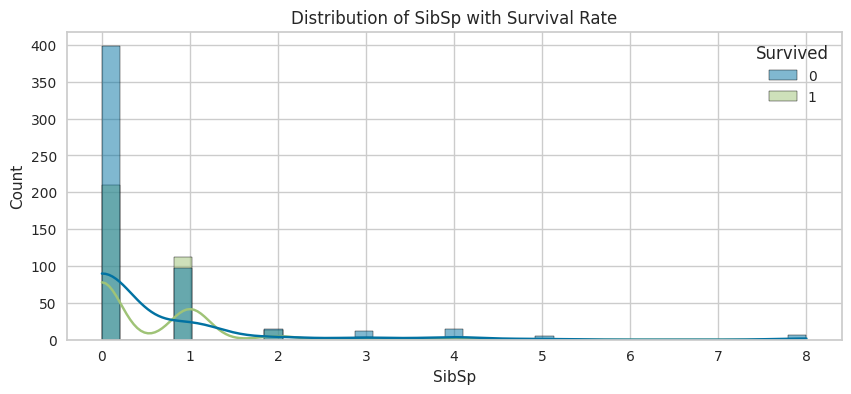

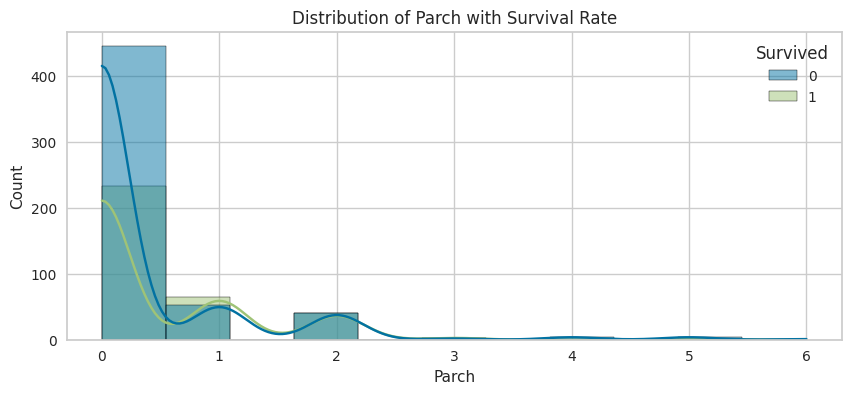

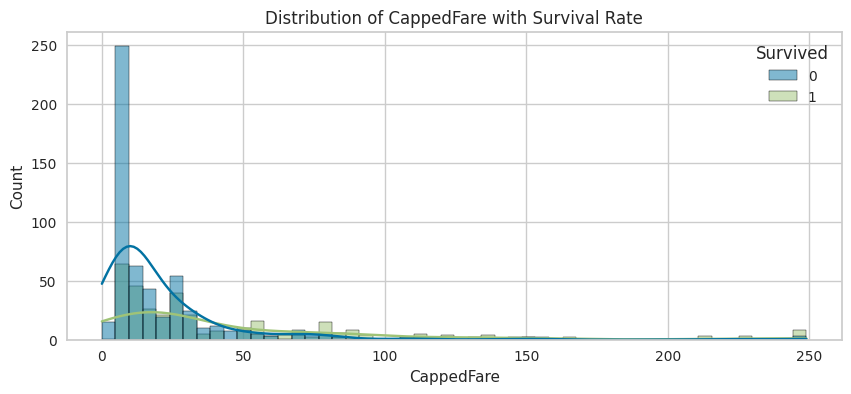

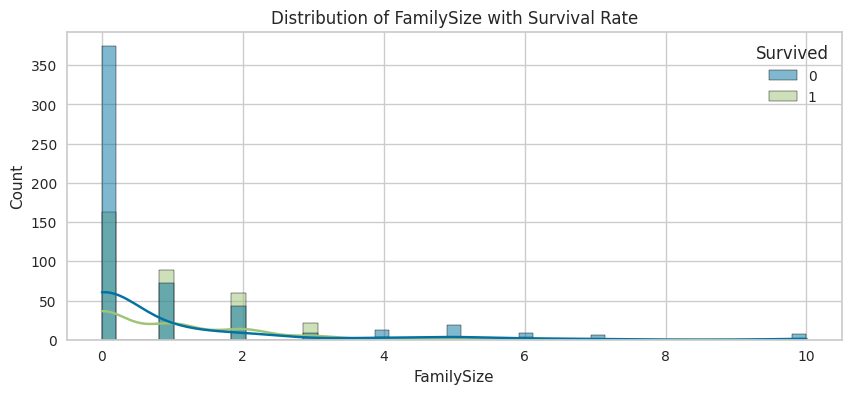

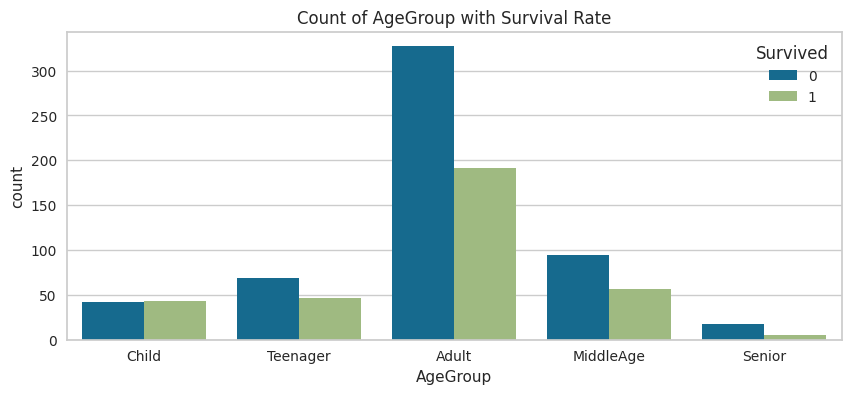

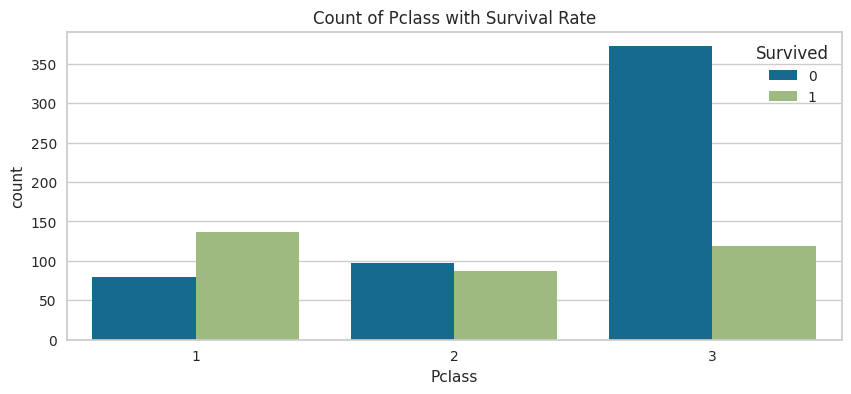

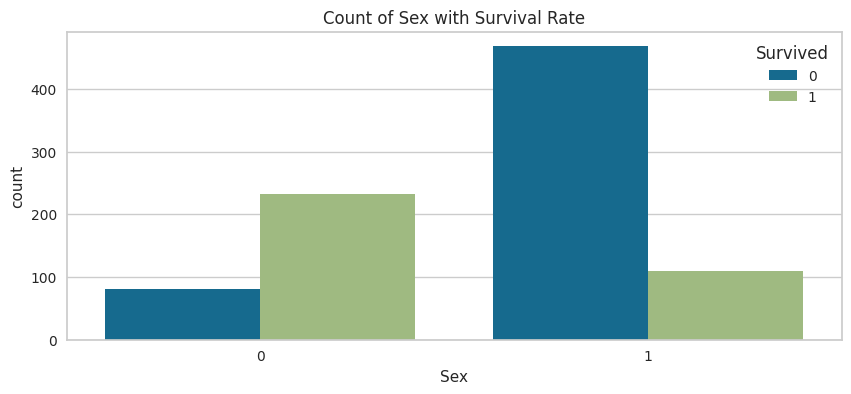

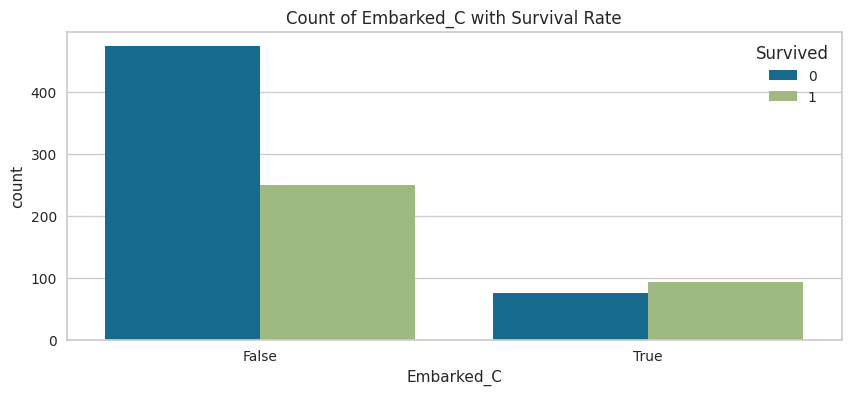

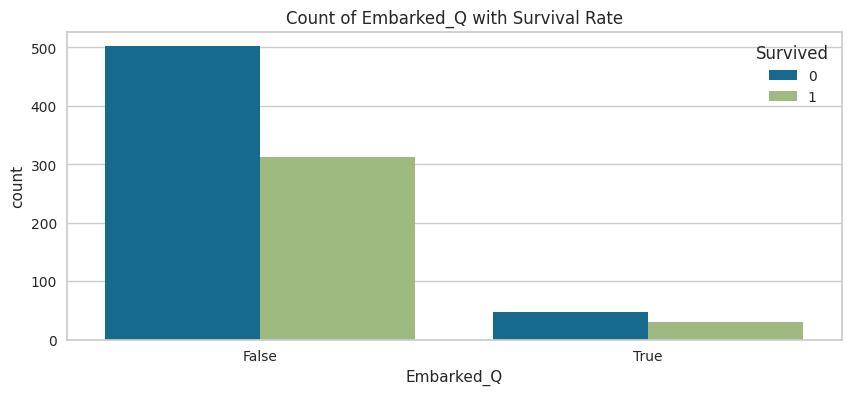

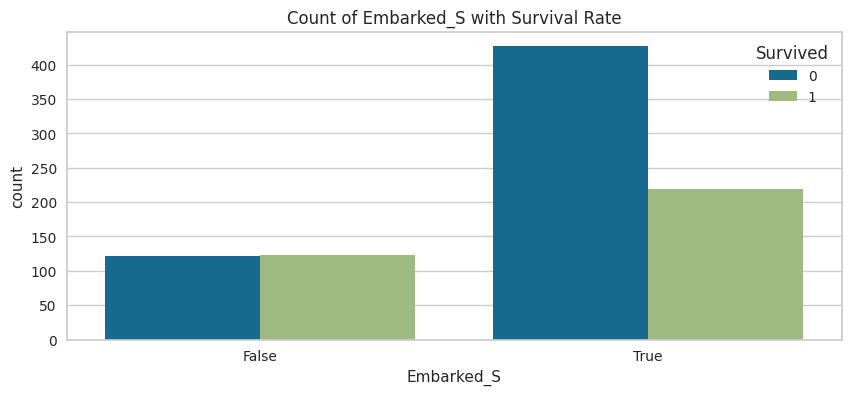

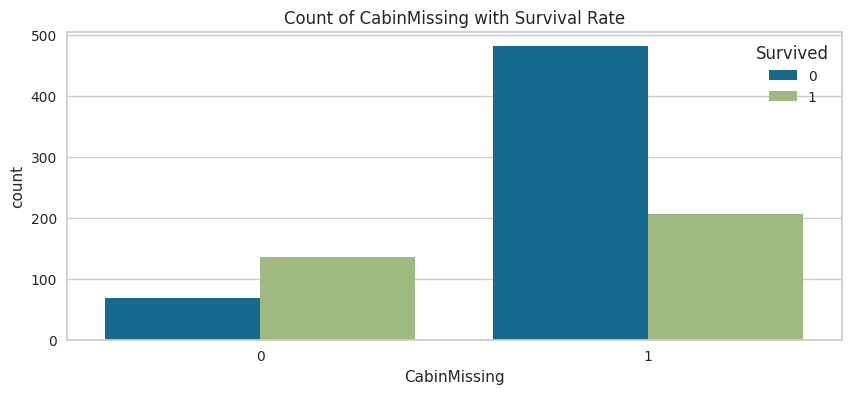

Training and Evaluating Model...
Training and Evaluating lr model with Cross-Validation...
Cross-Validation Scores: [0.83916084 0.82517483 0.84507042 0.79577465 0.82394366]
Average Score: 0.8258248793460062


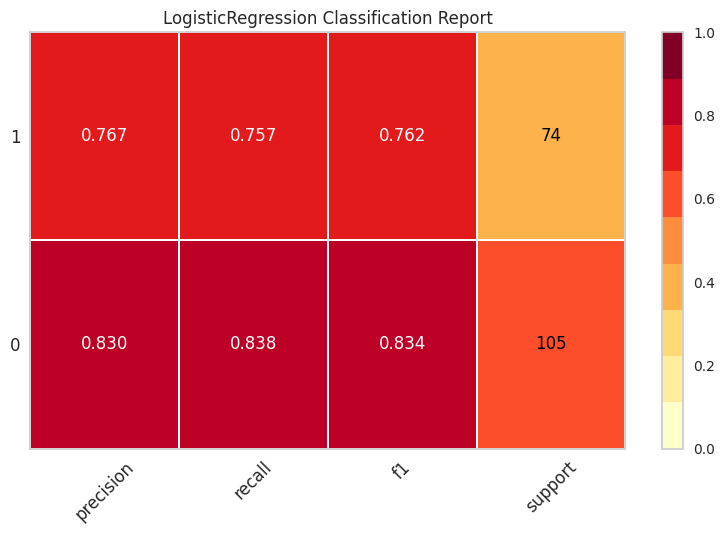

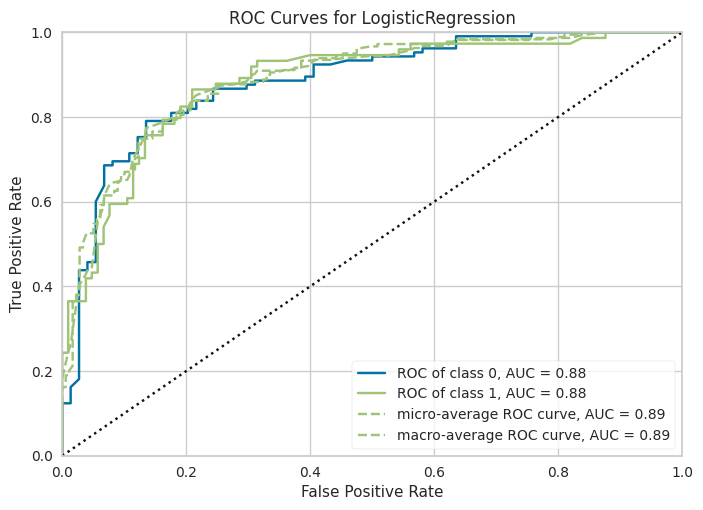

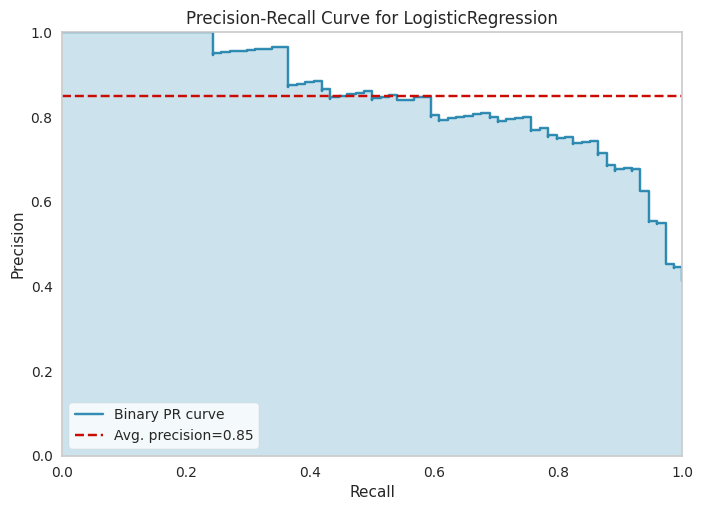

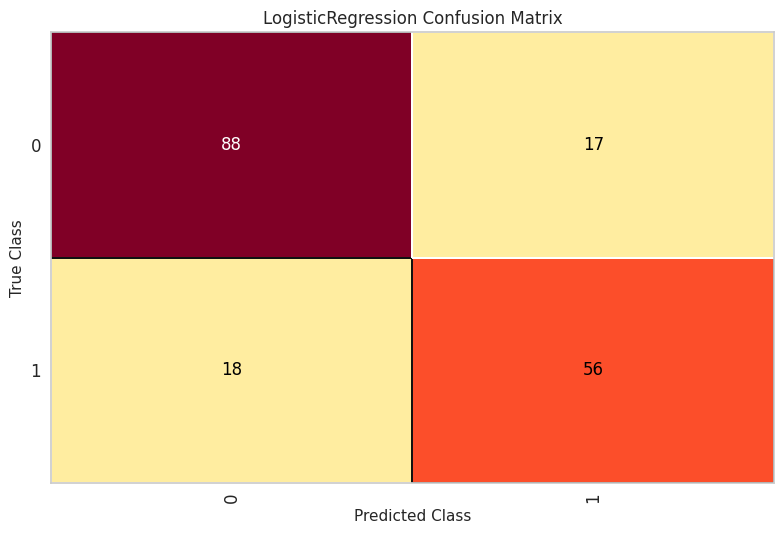

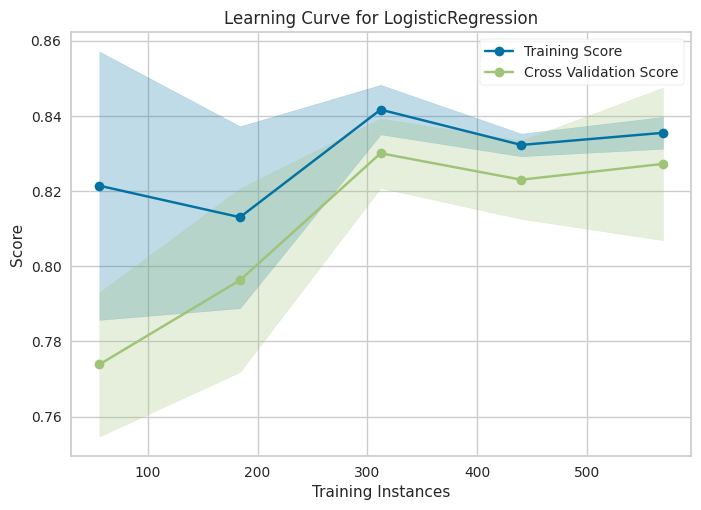

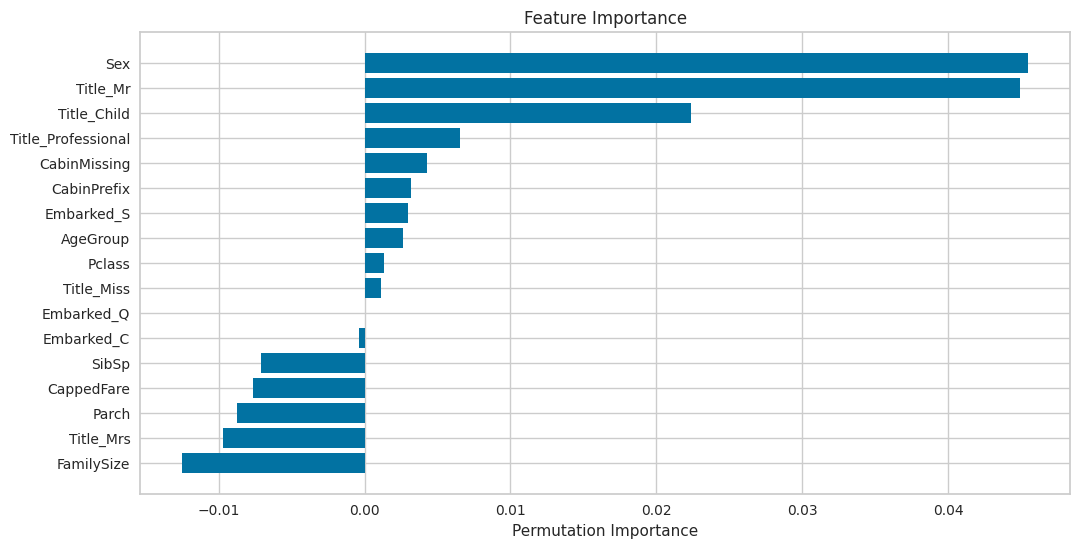

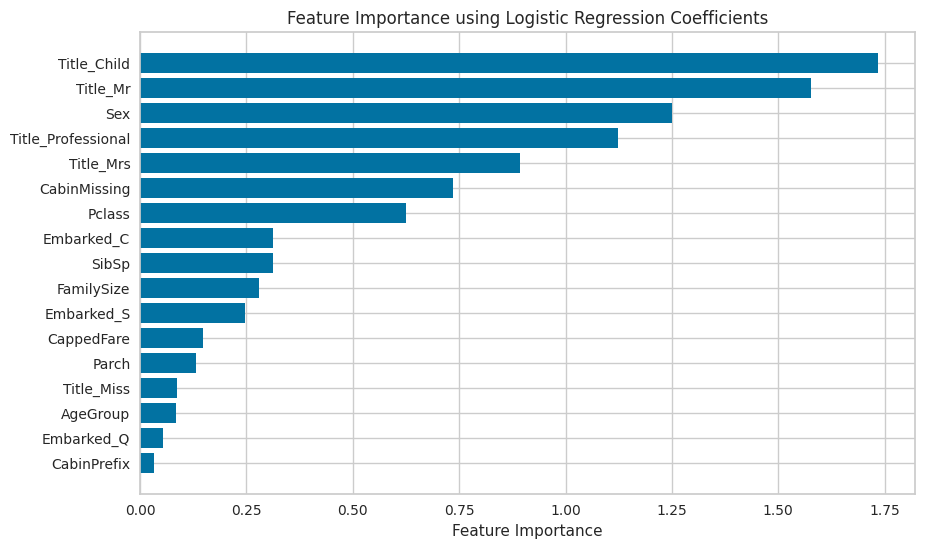

In [6]:
dp = DataPreprocessor(df)

new_df, model, scaler, encoder_c, encoder_a= dp.main_pipeline(model_type = 'lr')

In [7]:
new_df.info()
new_df['CabinPrefix'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Survived            891 non-null    int64   
 1   Pclass              891 non-null    int64   
 2   Sex                 891 non-null    int64   
 3   SibSp               891 non-null    int64   
 4   Parch               891 non-null    int64   
 5   Title_Child         891 non-null    bool    
 6   Title_Miss          891 non-null    bool    
 7   Title_Mr            891 non-null    bool    
 8   Title_Mrs           891 non-null    bool    
 9   Title_Professional  891 non-null    bool    
 10  CappedFare          891 non-null    float64 
 11  CabinMissing        891 non-null    int64   
 12  CabinPrefix         891 non-null    object  
 13  Embarked_C          891 non-null    bool    
 14  Embarked_Q          891 non-null    bool    
 15  Embarked_S          891 non-null    bool

CabinPrefix
unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64

In [8]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
print(test_df.shape)
test_df.head()

pid = test_df['PassengerId']

(418, 11)


In [9]:
new_dp = DataPreprocessor(test_df)

dp_test_df = new_dp.main_pipeline(dataset_type = 'Test')

Loading and Preprocessing Data...


In [10]:
dp_test_df['CabinPrefix'].value_counts()

CabinPrefix
unknown    327
C           35
B           18
D           13
E            9
F            8
A            7
G            1
Name: count, dtype: int64

In [11]:
encoder_c.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'unknown'], dtype=object)

In [ ]:
# Scaling numerical features
numerical_features = [ 'SibSp', 'Parch', 'CappedFare', 'FamilySize']
dp_test_df[numerical_features] = scaler.transform(dp_test_df[numerical_features])

# Encoding categorical features
categorical_features = [ 'CabinPrefix']  # Add other categorical features here
for feature in categorical_features:
    if feature in dp_test_df.columns:
        dp_test_df[feature] = encoder_c.transform(dp_test_df[feature])
        
# Encoding categorical features
categorical_features = [ 'AgeGroup']  # Add other categorical features here
for feature in categorical_features:
    if feature in dp_test_df.columns:
        dp_test_df[feature] = encoder_a.transform(dp_test_df[feature])

In [ ]:
dp_test_df[dp_test_df['CappedFare'].isna()]

dp_test_df['CappedFare'].fillna(-0.524806, inplace = True)

In [ ]:
pred = model.predict(dp_test_df)

In [ ]:
# Create a dictionary with the required columns
submission_dict = {
    'PassengerId': pid,
    'Survived': pred
}

# Convert the dictionary to a dataframe
submission_df = pd.DataFrame(submission_dict)

# Write the dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df.head()

### Conclusion

In conclusion, this notebook presents a thorough journey through the Titanic dataset, demonstrating a structured approach to data preprocessing, feature engineering, and model evaluation. The DataPreprocessor class serves as a modular and reusable component, encapsulating all the necessary steps for data transformation and preparation.

The exploratory data analysis provided valuable insights into the dataset, revealing crucial factors that influence survival rates. Subsequently, various machine learning models were trained and evaluated, offering a comparative view of their performance.

This exercise not only reinforces the importance of meticulous data preparation in machine learning but also illustrates the power of Python and its libraries in handling, analyzing, and modeling complex datasets. The techniques and methodologies applied here can be adapted and extended to other classification problems, making this notebook a valuable resource for both beginners and experienced practitioners in the field of data science.